In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform


In [ ]:
df = pd.read_csv("cleaned_heart_disease_data.csv")

In [5]:
X = df.drop(columns=['num'])
df['num'] = np.where(df['num']>0,1,0)
y = df['num']

### Feature selection using random forest and XGBoost


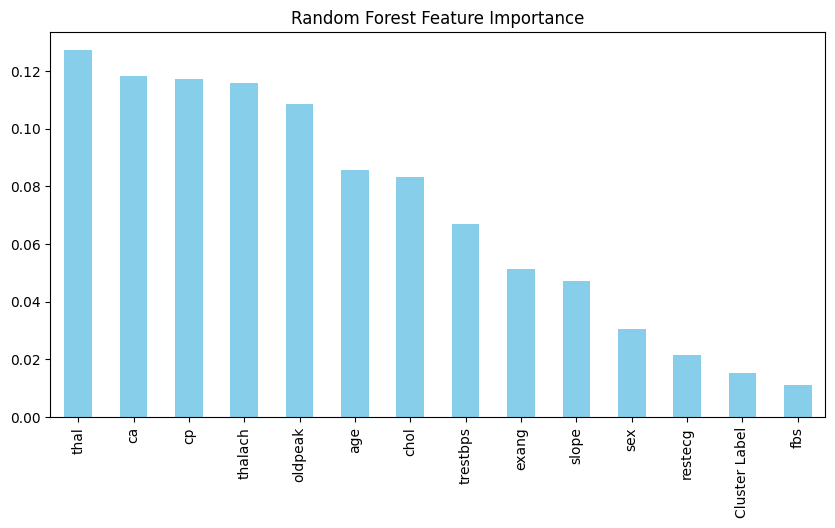

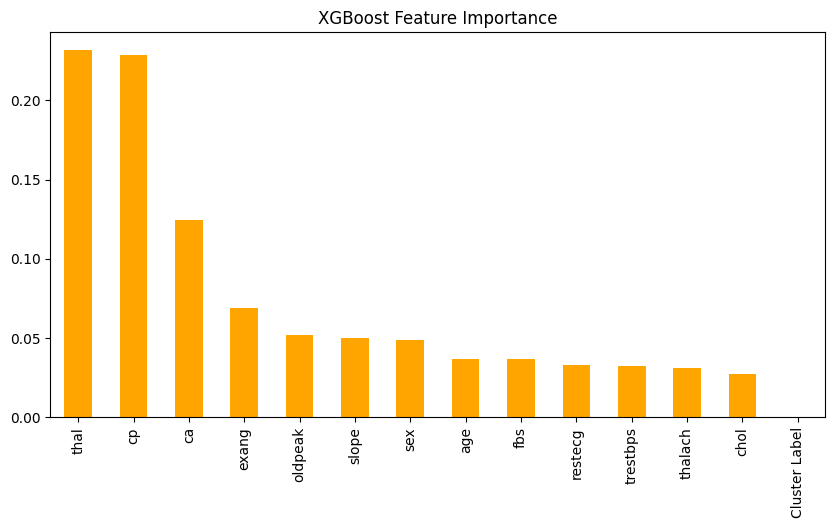

In [6]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# XGBoost feature importance
xgb_model = xgb.XGBClassifier(eval_metric='logloss')
xgb_model.fit(X, y)
xgb_importances = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot Random Forest importances
plt.figure(figsize=(10, 5))
rf_importances.plot(kind='bar', color='skyblue')
plt.title('Random Forest Feature Importance')
plt.show()

# Plot XGBoost importances
plt.figure(figsize=(10, 5))
xgb_importances.plot(kind='bar', color='orange')
plt.title('XGBoost Feature Importance')
plt.show()

### RFE for feature elimination using XGboost


In [7]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier( eval_metric='logloss')
xgb_model.fit(X, y)

rfe = RFE(estimator=xgb_model, n_features_to_select=13)
rfe.fit(X, y)

selected_features = X.columns[rfe.support_]

feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)

selected_feature_importances = feature_importances[selected_features]

selected_feature_importances = selected_feature_importances.sort_values(ascending=False)

print("Selected features with importance scores:")
print(selected_feature_importances)

Selected features with importance scores:
thal        0.231559
cp          0.228874
ca          0.124403
exang       0.069036
oldpeak     0.052039
slope       0.049645
sex         0.048629
age         0.036545
fbs         0.036517
restecg     0.032544
trestbps    0.031970
thalach     0.031035
chol        0.027203
dtype: float32


### Chi-Square Test to check feature significance

In [8]:
X_non_negative = X - np.min(X, axis=0)

chi2_selector = SelectKBest(chi2, k=13)
chi2_selector.fit(X_non_negative, y)

selected_features_chi2 = X.columns[chi2_selector.get_support()]

chi2_scores = chi2_selector.scores_

chi2_feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Chi2 Score': chi2_scores
})

# Filter only selected feature rows and sort by score descending
selected_feature_scores = chi2_feature_scores[chi2_feature_scores['Feature'].isin(selected_features_chi2)]
selected_feature_scores = selected_feature_scores.sort_values(by='Chi2 Score', ascending=False)

print("Selected features by Chi-Square Test with scores:")
print(selected_feature_scores)

Selected features by Chi-Square Test with scores:
          Feature  Chi2 Score
7         thalach  349.853519
12           thal  179.511859
11             ca   84.115181
9         oldpeak   67.271884
4            chol   61.658361
0             age   48.283012
3        trestbps   47.112343
8           exang   38.052613
13  Cluster Label   24.122085
2              cp   22.154638
10          slope   21.968672
6         restecg    8.644897
1             sex    7.432845


### Interscetion of Features


In [9]:
# 1. Intersection of feature names
intersection_features = list(set(selected_features) & set(selected_features_chi2))

# 2. Filter importance scores for intersection features
rfe_importances_intersect = selected_feature_importances[intersection_features]
chi2_scores_intersect = selected_feature_scores[selected_feature_scores['Feature'].isin(intersection_features)]

# 3. Normalize the scores to [0,1] range separately
rfe_norm = (rfe_importances_intersect - rfe_importances_intersect.min()) / (rfe_importances_intersect.max() - rfe_importances_intersect.min())
chi2_norm = (chi2_scores_intersect.set_index('Feature')['Chi2 Score'] - chi2_scores_intersect['Chi2 Score'].min()) / (chi2_scores_intersect['Chi2 Score'].max() - chi2_scores_intersect['Chi2 Score'].min())

# 4. Combine normalized scores into DataFrame
combined_scores = pd.DataFrame({
    'RFE Importance': rfe_norm,
    'Chi2 Score': chi2_norm
})

# 5. Calculate average score
combined_scores['Average Score'] = combined_scores.mean(axis=1)

# 6. Sort features by combined importance
combined_scores = combined_scores.sort_values(by='Average Score', ascending=False)

print("Intersected features ranked by combined importance scores:")
print(combined_scores)

Intersected features ranked by combined importance scores:
          RFE Importance  Chi2 Score  Average Score
thal            1.000000    0.502537       0.751268
cp              0.986863    0.042993       0.514928
thalach         0.018752    1.000000       0.509376
ca              0.475644    0.223942       0.349793
oldpeak         0.121534    0.174753       0.148144
exang           0.204708    0.089421       0.147065
age             0.045712    0.119298       0.082505
chol            0.000000    0.158359       0.079180
slope           0.109816    0.042450       0.076133
trestbps        0.023324    0.115879       0.069602
sex             0.104845    0.000000       0.052423
restecg         0.026137    0.003540       0.014838


In [10]:
X = df.drop(columns=['num','chol','trestbps'])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)